# Import packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from networkx.algorithms import approximation as aprx
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import regularizers, layers
from sklearn.linear_model import LinearRegression
import random

# Load data

In [2]:
# load data
df_train = pd.read_csv('council_data.csv')

In [3]:
df_train

,index,count,journey_time,edge
0,50,589,106.231573,d_c
1,4,681,80.044008,d_f
2,83,341,111.584124,a_c
3,30,569,102.704392,d_c
4,84,162,47.144924,b_d
...,...,...,...,...
795,28,511,72.968370,d_f
796,26,547,83.829218,s_b
797,49,378,81.543906,d_c
798,71,578,93.567254,a_c


In [4]:
df_dummy = pd.get_dummies(df_train)

In [5]:
df_sorted = df_dummy.sort_values(by=['index'])

In [405]:
df_sorted

,index,count,journey_time,edge_a_c,edge_b_d,edge_c_d,edge_c_e,edge_d_c,edge_d_f,edge_s_a,edge_s_b
33,0,627,95.546860,0,0,0,0,0,0,0,1
576,0,590,129.008191,0,0,0,0,0,0,1,0
420,0,693,147.538087,0,1,0,0,0,0,0,0
548,0,266,42.907473,0,0,0,0,0,1,0,0
754,0,757,112.620141,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
447,99,644,103.873021,1,0,0,0,0,0,0,0
89,99,992,119.075884,0,0,0,0,0,1,0,0
708,99,503,177.260751,0,0,0,1,0,0,0,0
48,99,518,87.722169,0,0,0,0,0,0,0,1


In [6]:
# convert into 1-hot encoding
df_dummy = pd.get_dummies(df_sorted)

# Data visualization

In [8]:
# columns names
edge_names = df_dummy.columns[3:]

In [9]:
xy_list = list()
for edge in edge_names: 
    x = df_dummy[df_dummy[edge] == 1]['count']
    y = df_dummy[df_dummy[edge] == 1]['journey_time']
    idx = df_dummy[df_dummy[edge] == 1]['index']
    xy_list.append([x,y,idx])
    print(len(x),len(y), len(idx))

100 100 100
100 100 100
100 100 100
100 100 100
100 100 100
100 100 100
100 100 100
100 100 100


In [373]:
# linear fit within points belonging to the same edge
def linear_fit(x_data, y_data):
    linear = LinearRegression(fit_intercept=True,normalize=True) # intercept is NOT set to 0
    linear.fit(x_data, y_data)
    
    return linear

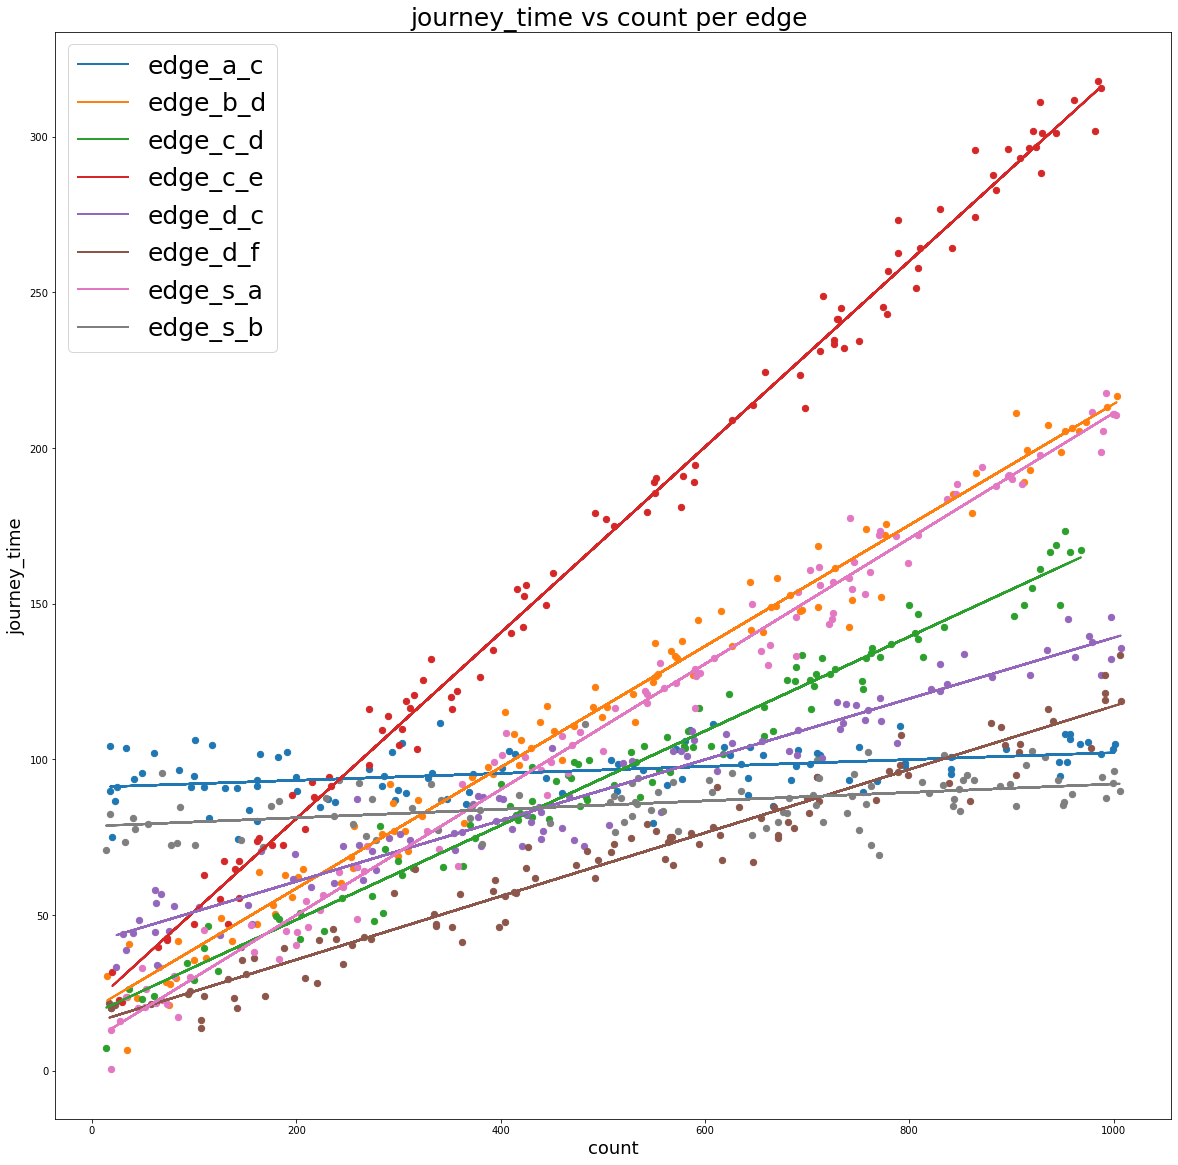

In [395]:
# plot points
plt.figure(figsize=(20,20))
plt.title('journey_time vs count per edge ', fontsize=25)
plt.xlabel('count', fontsize=18)
plt.ylabel('journey_time', fontsize=18)

fits = list()
for edge in range(len(xy_list)):
    # fit to data to corresponding edge
    x = xy_list[edge][0].to_numpy().reshape(-1,1)
    y = xy_list[edge][1].to_numpy().reshape(-1,1)
    
    fits.append(linear_fit(x, y))
    fit = fits[edge]
    
    # plot data and fit
    plt.plot(x, fit.coef_*x+fit.intercept_, '-', linewidth=2.)
    plt.scatter(xy_list[edge][0], xy_list[edge][1], marker='o',s=40)
    
plt.legend(edge_names, loc='upper left', prop={'size': 25})


In [375]:
# sum 'count' per each index
sum_list = list()
for index in index_names: 
    df_count = df_train[df_index_dummy[index] == 1]['count']
    sum_list.append(np.sum(df_count))

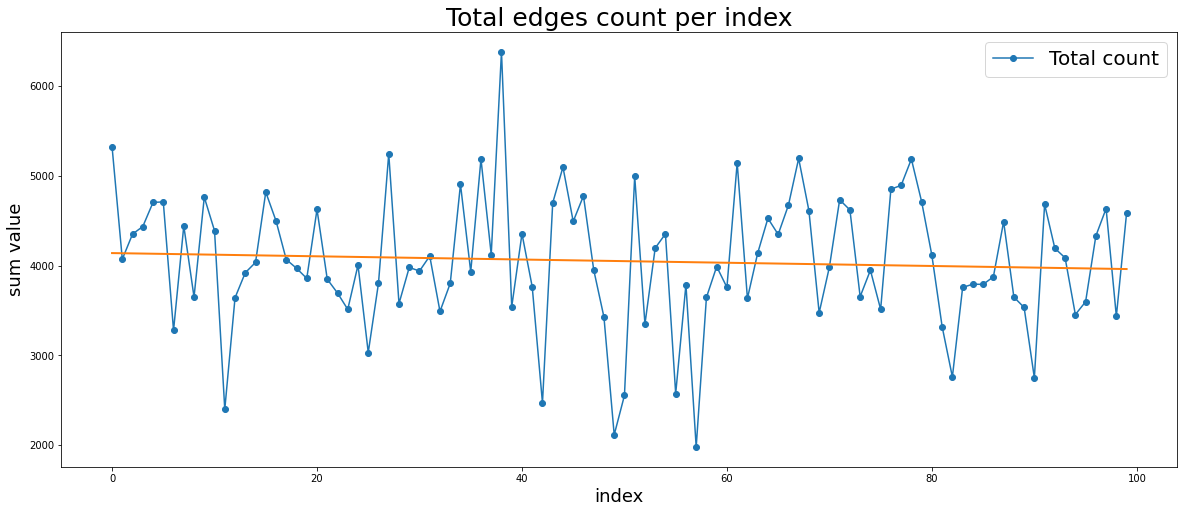

In [392]:
# plot points    
plt.figure(figsize=(20,8))
plt.title('Total edges count per index', fontsize=25)
plt.xlabel('index', fontsize=18)
plt.ylabel('sum value', fontsize=18)
indices = np.arange(len(sum_list))
plt.plot(indices, sum_list, marker='o')

x = indices.reshape(-1,1)
y =  np.array(sum_list).reshape(-1,1)
fit = linear_fit(x, y)
plt.plot(x, fit.coef_*x+fit.intercept_, '-', linewidth=2.)

plt.legend(['Total count'], loc='upper right', prop={'size': 20})

# Current traffic model

This is the model without tunnel.

In [330]:
# calculates journey time from current traffic on a given path
def calculate_journey_time(count_line, edges_list, fits):
    
    total_journey_time = 0 
    
    for edge in edges_list:
        
        if edge != 8 and edge !=9:
            fit = fits[edge]
            #print(fit.coef_[0][0], fit.intercept_[0])
            journey_time = fit.coef_[0][0]*count_line[edge]+fit.intercept_[0]
        else:
            journey_time = 4*60 # 4 minutes
        
        total_journey_time += journey_time
    
    return total_journey_time, np.sum(count_line[edges_list])

In [182]:
# label edges with integers
all_edges = ['ac','bd','cd','ce','dc','df','sa','sb']
sace_edges = [6,0,3]
sbdce_edges = [7,1,4,3]
sbdf_edges = [7,1,5]
sacdf_edges = [6,0,2,5]  

In [214]:
# define all the possible paths
all_paths = ['sace', 'sbdce', 'sbdf', 'sacdf']
se_paths = [sace_tunnel_edges, sbdce_tunnel_edges]
sf_paths = [sbdf_tunnel_edges, sacdf_tunnel_edges]

In [295]:
# define tunnel count
np_count = np.zeros([len(index_names),8])

# keep count of paths choice by each driver
paths_count_se = np.zeros([len(index_names),2])
paths_count_sf = np.zeros([len(index_names),2])

# keep track of journy_time for each paths choice by each driver
paths_journeytime_se = np.zeros([len(index_names),2])
paths_journeytime_sf = np.zeros([len(index_names),2])

The functions below determine the driver path choice for both s->e and s->f. The two functions have a very similar structure, they only differ in the paths.

In [296]:
def fill_se():
    # reset lists
    se_times = list()
            
    # look for the path with the minimum journey_time
    sace_time, _ = calculate_journey_time(np_count[int(index),:], sace_edges, fits)
    sbdce_time, _ = calculate_journey_time(np_count[int(index),:], sbdce_edges, fits)
            
    # journey_time for each path
    se_times.append([sace_time, sbdce_time])
    
    # increase journey_time for best path (path with shorter journey_time)
    paths_journeytime_se[int(index),np.argmin(se_times)] += se_times[0][np.argmin(se_times)]
        
    # increase count on a randomly chosen edge on the best path
    np_count[int(index), random.choice(se_paths[np.argmin(se_times)])] +=1
            
    # add driver to paths count
    paths_count_se[int(index),np.argmin(se_times)] +=1

In [297]:
def fill_sf():
    # reset lists
    sf_times = list()
            
    # look for the path with the minimum journey_time
    sbdf_time, _ = calculate_journey_time(np_count[int(index),:], sbdf_edges, fits)
    sacdf_time, _ = calculate_journey_time(np_count[int(index),:], sacdf_edges, fits)

    # journey_time for each path
    sf_times.append([sbdf_time, sacdf_time])
    
    # increase journey_time for best path
    paths_journeytime_sf[int(index),np.argmin(sf_times)] += sf_times[0][np.argmin(sf_times)]
    
    # increase count on a randomly chosen edge on the best path
    np_count[int(index), random.choice(sf_paths[np.argmin(sf_times)])] +=1
            
    # add driver to paths count
    paths_count_sf[int(index),np.argmin(sf_times)] +=1

The next function generates the traffic routes, by looping over each index and each driver, and determine the path followed by each driver

In [298]:
# fill np_count
for index in index_names:
    
    # get total number of drivers for each index
    n_drivers = sum_list[int(index)]
    
    # loop on each driver
    for driver in range(n_drivers):
        
        # driver chooses between s->e and s->f with different probability
        path = np.random.choice(['se','sf'], p=[0.35, 0.65])
        
        # check first path
        if path == 'se':
            fill_se()

        # check other path
        elif path == 'sf':
            fill_sf()

In [299]:
# fill np_journeytime
np_journeytime = np.zeros([len(index_names),8])

# loop over edge
for edge in range(len(edge_names)):
    fit = fits[edge]
    np_journeytime[:, edge] = fit.coef_[0][0]*np_count[:, edge]+fit.intercept_[0]

## Display results

In [308]:
# number of drivers per path
paths_count = np.hstack((paths_count_se, paths_count_sf))
df_paths = pd.DataFrame (paths_count.astype(int), \
                                columns = all_paths)
df_paths

,sace,sbdce,sbdf,sacdf
0,1895,0,2938,492
1,1420,0,2263,388
2,1498,0,2435,418
3,1533,0,2445,457
4,1624,0,2596,484
...,...,...,...,...
95,1262,0,2008,327
96,1526,0,2414,390
97,1623,0,2574,438
98,1211,0,1939,285


In [353]:
# average journey_time per path
paths_journeytime = np.hstack((paths_journeytime_se, paths_journeytime_sf))

average_time = paths_journeytime/paths_count
df_average_time = pd.DataFrame (average_time, columns = all_paths)
df_average_time

/Users/alfredo/Documents/Python/venv/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


,sace,sbdce,sbdf,sacdf
0,291.856883,NaN,266.661633,317.854807
1,252.330226,NaN,235.025827,263.411739
2,261.602519,NaN,244.040052,276.503250
3,263.396631,NaN,243.587417,286.738683
4,268.438597,NaN,251.557956,275.429182
...,...,...,...,...
95,235.013670,NaN,221.040852,258.819191
96,258.065902,NaN,236.373007,273.816748
97,269.894592,NaN,251.535207,285.390572
98,227.379715,NaN,218.374231,258.772265


In [410]:
# number of drivers per edge
df_count = pd.DataFrame (np_count.astype(int), columns = all_edges)
df_count

,ac,bd,cd,ce,dc,df,sa,sb
0,743,964,133,636,0,1118,754,977
1,557,761,105,474,0,836,575,763
2,579,806,103,509,0,933,621,800
3,617,816,114,532,0,947,620,789
4,680,863,122,521,0,981,659,878
...,...,...,...,...,...,...,...,...
95,501,673,71,406,0,751,516,679
96,606,774,99,514,0,882,596,859
97,662,853,103,528,0,1006,662,821
98,467,648,77,387,0,746,482,628


In [312]:
# journey_time per edge with full traffic (traffic count shown in table above)
df_journeytime = pd.DataFrame (np_journeytime, columns = all_edges)
df_journeytime

,ac,bd,cd,ce,dc,df,sa,sb
0,99.327618,207.160010,38.330125,211.105060,41.233197,129.180208,161.691677,91.805930
1,97.262721,167.678696,34.085261,162.754409,41.233197,100.461915,125.602333,88.907597
2,97.506956,176.430711,33.782056,173.200538,41.233197,110.340193,134.876689,89.408710
3,97.928817,178.375604,35.449682,180.065136,41.233197,111.765924,134.675073,89.259731
4,98.628217,187.516598,36.662500,176.782067,41.233197,115.228413,142.538114,90.465112
...,...,...,...,...,...,...,...,...
95,96.641031,150.563643,28.930783,142.459074,41.233197,91.805692,113.706962,87.769933
96,97.806699,170.207056,33.175647,174.692842,41.233197,105.146459,129.836278,90.207783
97,98.428388,185.571705,33.782056,178.871293,41.233197,117.774361,143.142964,89.693126
98,96.263577,145.701412,29.840397,136.788319,41.233197,91.296502,106.852003,87.079209


# Traffic model with tunnel

Tunnel enables two new edges, ab and ba. Maximum total capacity is 400, it takes a constant time of 4 minutes to get through the tunnel, on both directions.

In [189]:
# edges list with the additional tunnel
all_tunnel_edges = ['ac','bd','cd','ce','dc','df','sa','sb','ab','ba']

In [127]:
# from s to e
sace_tunnel_edges = [6,0,3]
sbdce_tunnel_edges = [7,1,4,3]
sbace_tunnel_edges = [7,9,0,3]
sabdce_tunnel_edges = [6,8,1,4,3]

# from s to f
sbdf_tunnel_edges = [7,1,5]
sacdf_tunnel_edges = [6,0,2,5]  
sabdf_tunnel_edges = [6,8,1,5]
sbacdf_tunnel_edges = [7,9,0,2,5]

In [202]:
# all possible paths with tunnel
all_tunnel_paths = ['sace', 'sbdce', 'sbace', 'sabdce', 'sbdf', 'sacdf', 'sabdf', 'sbacdf']
se_tunnel_paths = [sace_tunnel_edges, sbdce_tunnel_edges, sbace_tunnel_edges, sabdce_tunnel_edges]
sf_tunnel_paths = [sbdf_tunnel_edges, sacdf_tunnel_edges, sabdf_tunnel_edges, sbacdf_tunnel_edges]

In [342]:
# define tunnel count
np_tunnel_count = np.zeros([len(index_names),10])

# keep count of paths choice by each driver
paths_tunnel_count_se = np.zeros([len(index_names),4])
paths_tunnel_count_sf = np.zeros([len(index_names),4])

# keep track of journy_time for each paths choice by each driver
paths_tunnel_journeytime_se = np.zeros([len(index_names),4])
paths_tunnel_journeytime_sf = np.zeros([len(index_names),4])

The functions below determine the driver path choice for both s->e and s->f

In [343]:
def fill_tunnel_se():
    se_times = list()
    # look for the path with the minimum journey_time
    sace_time, _ = calculate_journey_time(np_tunnel_count[int(index),:], sace_tunnel_edges, fits)
    sbdce_time, _ = calculate_journey_time(np_tunnel_count[int(index),:], sbdce_tunnel_edges, fits)
    sbace_time, _ = calculate_journey_time(np_tunnel_count[int(index),:], sbace_tunnel_edges, fits)
    sabdce_time, _ = calculate_journey_time(np_tunnel_count[int(index),:], sabdce_tunnel_edges, fits)
        
    # consider additional tunnel paths only if tunnel is not on full demand, then fill edges within path
    if np_tunnel_count[int(index),8] + np_tunnel_count[int(index),9] <= 400:
        
        # journey_time for each path
        se_times.append([sace_time, sbdce_time, sbace_time, sabdce_time])
        
        # increase journey_time for best path
        paths_tunnel_journeytime_se[int(index),np.argmin(se_times)] += se_times[0][np.argmin(se_times)]
        
        # increase count on a randomly chosen edge on the best path
        np_tunnel_count[int(index), random.choice(se_tunnel_paths[np.argmin(se_times)])] +=1
      
    # same operations when the tunnel is filled
    else:
        se_times.append([sace_time, sbdce_time])
        paths_tunnel_journeytime_se[int(index),np.argmin(se_times)] += se_times[0][np.argmin(se_times)]
        np_tunnel_count[int(index), random.choice(se_paths[np.argmin(se_times)])] +=1
     
    # add driver to paths count
    paths_tunnel_count_se[int(index),np.argmin(se_times)] +=1

In [344]:
def fill_tunnel_sf():
    sf_times = list()
    # look for the path with the minimum journey_time
    sbdf_time, _ = calculate_journey_time(np_tunnel_count[int(index),:], sbdf_tunnel_edges, fits)
    sacdf_time, _ = calculate_journey_time(np_tunnel_count[int(index),:], sacdf_tunnel_edges, fits)
    sabdf_time, _ = calculate_journey_time(np_tunnel_count[int(index),:], sabdf_tunnel_edges, fits)
    sbacdf_time, _ = calculate_journey_time(np_tunnel_count[int(index),:], sbacdf_tunnel_edges, fits)
            
    # consider additional tunnel paths only if tunnel is not on full demand, then fill edges within path 
    if np_tunnel_count[int(index),8] + np_tunnel_count[int(index),9] <= 400:
        
        # journey_time for each path
        sf_times.append([sace_time, sbdce_time, sabdf_time, sbacdf_time])
        
        # increase journey_time for best path
        paths_tunnel_journeytime_sf[int(index),np.argmin(sf_times)] += sf_times[0][np.argmin(sf_times)]
        
        # increase count on a randomly chosen edge on the best path
        np_tunnel_count[int(index), random.choice(sf_tunnel_paths[np.argmin(sf_times)])] +=1
    
    # same operations when the tunnel is filled
    else:
        sf_times.append([sace_time, sbdce_time])
        paths_tunnel_journeytime_sf[int(index),np.argmin(sf_times)] += sf_times[0][np.argmin(sf_times)]
        np_tunnel_count[int(index), random.choice(sf_paths[np.argmin(sf_times)])] +=1
            
    # add driver to paths count
    paths_tunnel_count_sf[int(index),np.argmin(sf_times)] +=1

The next function generates the traffic routes, by looping over each index and each driver, and determine the path followed by each driver

In [345]:
# fill np_count
for index in index_names:
    
    # get total number of drivers for each index
    n_drivers = sum_list[int(index)]
    
    # loop on each driver
    for driver in range(n_drivers):
        
        # driver chooses between s->e and s->f with different probability
        path = np.random.choice(['se','sf'], p=[0.35, 0.65])
        
        # check first path
        if path == 'se':
            fill_tunnel_se()
                
        # check other path  
        elif path == 'sf':
            fill_tunnel_sf()

In [347]:
# fill np_journeytime
np_tunnel_journeytime = np.zeros([len(index_names),10])

# loop over edge
for edge in range(len(all_tunnel_edges)):
    
    # make exception for edges ab and ba, their journey time is constant
    if edge != 8 and edge != 9:
        fit = fits[edge]
        np_tunnel_journeytime[:, edge] = fit.coef_[0][0]*np_tunnel_count[:, edge]+fit.intercept_[0]
    else:
        np_tunnel_journeytime[:, edge] = 4*60 #4 minutes

## Display results

In [348]:
# number of drivers per path
paths_tunnel_count = np.hstack((paths_tunnel_count_se, paths_tunnel_count_sf))
df_tunnel_paths = pd.DataFrame (paths_tunnel_count.astype(int), columns = all_tunnel_paths)
df_tunnel_paths

,sace,sbdce,sbace,sabdce,sbdf,sacdf,sabdf,sbacdf
0,1916,0,0,0,2452,0,957,0
1,1336,0,0,0,1761,0,974,0
2,1518,15,0,0,1905,0,913,0
3,1574,12,0,0,1914,0,935,0
4,1590,16,0,0,2162,0,936,0
...,...,...,...,...,...,...,...,...
95,1256,0,0,0,1370,0,971,0
96,1543,0,0,0,1819,0,968,0
97,1641,24,0,0,1997,0,973,0
98,1206,0,0,0,1294,0,935,0


In [349]:
# average journey_time per path
paths_tunnel_journeytime = np.hstack((paths_tunnel_journeytime_se, paths_tunnel_journeytime_sf))

average_tunnel_time = paths_tunnel_journeytime/paths_tunnel_count
df_average_tunnel_time = pd.DataFrame (average_tunnel_time, columns = all_tunnel_paths)
df_average_tunnel_time

/Users/alfredo/Documents/Python/venv/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


,sace,sbdce,sbace,sabdce,sbdf,sacdf,sabdf,sbacdf
0,322.507680,NaN,NaN,NaN,436.340449,NaN,359.729494,NaN
1,278.722272,NaN,NaN,NaN,436.340449,NaN,361.366695,NaN
2,293.897515,256.916217,NaN,NaN,436.340449,NaN,360.905506,NaN
3,296.509676,259.091126,NaN,NaN,436.340449,NaN,360.805457,NaN
4,296.396643,250.888463,NaN,NaN,436.340449,NaN,361.437351,NaN
...,...,...,...,...,...,...,...,...
95,264.207134,NaN,NaN,NaN,436.340449,NaN,361.738357,NaN
96,290.017778,NaN,NaN,NaN,436.340449,NaN,361.402318,NaN
97,308.395474,255.406367,NaN,NaN,436.340449,NaN,361.628835,NaN
98,261.643376,NaN,NaN,NaN,436.340449,NaN,361.662061,NaN


In [350]:
# number of drivers per edge
df_tunnel_count = pd.DataFrame (np_tunnel_count.astype(int), columns = all_tunnel_edges)
df_tunnel_count

,ac,bd,cd,ce,dc,df,sa,sb,ab,ba
0,623,1069,0,639,0,1063,880,814,237,0
1,421,835,0,453,0,769,712,626,255,0
2,497,859,0,543,3,836,726,667,220,0
3,520,875,0,513,3,874,777,645,228,0
4,557,919,0,516,6,979,770,741,216,0
...,...,...,...,...,...,...,...,...,...,...
95,419,690,0,447,0,728,614,450,249,0
96,513,861,0,495,0,831,756,611,263,0
97,539,897,0,582,4,902,776,691,244,0
98,382,670,0,421,0,670,614,459,219,0


In [351]:
# journey_time per edge with full traffic
df_tunnel_journeytime = pd.DataFrame (np_tunnel_journeytime, columns = all_tunnel_edges)
df_tunnel_journeytime

,ac,bd,cd,ce,dc,df,sa,sb,ab,ba
0,97.995426,227.581380,18.16702,212.000443,41.233197,123.579123,187.095350,89.598321,240.0,240.0
1,95.752903,182.070899,18.16702,156.486732,41.233197,93.638774,153.223786,87.052122,240.0,240.0
2,96.596625,186.738641,18.16702,183.348205,41.526803,100.461915,156.046417,87.607410,240.0,240.0
3,96.851961,189.850468,18.16702,174.394381,41.526803,104.331756,166.328855,87.309451,240.0,240.0
4,97.262721,198.407995,18.16702,175.289763,41.820409,115.024737,164.917540,88.609637,240.0,240.0
...,...,...,...,...,...,...,...,...,...,...
95,95.730700,153.869960,18.16702,154.695967,41.233197,89.463419,133.465374,84.668446,240.0,240.0
96,96.774250,187.127619,18.16702,169.022086,41.233197,99.952725,162.094910,86.848968,240.0,240.0
97,97.062892,194.129231,18.16702,194.988177,41.624672,107.183217,166.127239,87.932457,240.0,240.0
98,95.319941,149.980175,18.16702,146.935986,41.233197,83.556820,133.465374,84.790339,240.0,240.0


# Compute means

In [404]:
df_paths.mean(axis=0).astype(int)

sace     1418
sbdce       0
sbdf     2250
sacdf     381
dtype: int64

In [403]:
df_tunnel_paths.mean(axis=0).astype(int)

sace      1405
sbdce       14
sbace        0
sabdce       0
sbdf      1685
sacdf        0
sabdf      945
sbacdf       0
dtype: int64

In [398]:
df_average_time.mean(axis=0)

sace     250.320142
sbdce           NaN
sbdf     232.750476
sacdf    269.941837
dtype: float64

In [399]:
df_average_tunnel_time.mean(axis=0)

sace      281.279201
sbdce     252.520787
sbace            NaN
sabdce           NaN
sbdf      436.340449
sacdf            NaN
sabdf     360.743302
sbacdf           NaN
dtype: float64

In [414]:
df_count.mean(axis=0).astype(int)

ac    565
bd    749
cd     95
ce    472
dc      0
df    843
sa    569
sb    754
dtype: int64

In [415]:
df_tunnel_count.mean(axis=0).astype(int)

ac    466
bd    800
cd      0
ce    475
dc      3
df    798
sa    703
sb    565
ab    237
ba      0
dtype: int64

# Graphs visualization

In [186]:
G = nx.nx.DiGraph()
G.add_nodes_from(['a','b','c','d','e','f'])
G.add_edges_from([('a','c'),('b','d'),('c','d'),('c','e'),('d','c'), ('d','f'), ('s','a'),('s','b')])

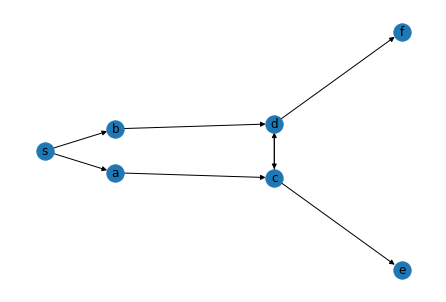

In [204]:
nx.draw_spectral(G, with_labels=True) 

In [303]:
G_upgrade = nx.DiGraph()
G_upgrade.add_nodes_from(['a','b','c','d','e','f'])
G_upgrade.add_edges_from([('a','c'),('b','d'),('c','d'),('c','e'),('d','c'), ('d','f'), ('s','a'),('s','b'),
                         ('a','b'),('b','a')])

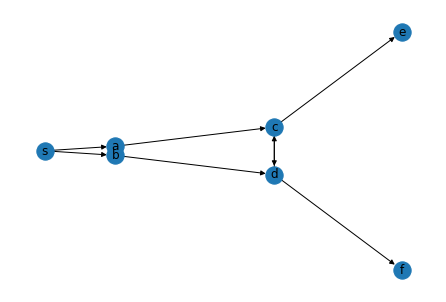

In [304]:
nx.draw_spectral(G_upgrade, with_labels=True) 